# Lesson 7: Classification

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

We will use the Kaggle Titanic data to demonstrate these major steps.
- Data: https://www.kaggle.com/competitions/titanic/data
- Examples used to compose this notebook: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions

In [2]:
# Import data from Kaggle Competition
PATH = "../../data/titanic"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
df.drop(["Cabin"], axis=1, inplace=True)
df.dropna(subset=['Embarked'], inplace=True)

df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


In [3]:
# train-test-split
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)
combine = [df_train, df_test]

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [6]:
# perform data preprocessing separately on each subset:
# 1) converting male and female to 0 and 1
# 2) imputing age based on median value for given class and sex
# 3) converting embarked in S to 0, embarked in C to 1, and embarked in Q to 2

for dataset in combine:

    # convert categorical features into numbers
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # fill the missing values for Age
    guess_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            guess_ages[i,j] = guess_df.median()
           
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)
    

In [7]:
for dataset in combine:
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  755 non-null    int64  
 1   Pclass    755 non-null    int64  
 2   Name      755 non-null    object 
 3   Sex       755 non-null    int64  
 4   Age       755 non-null    int64  
 5   SibSp     755 non-null    int64  
 6   Parch     755 non-null    int64  
 7   Ticket    755 non-null    object 
 8   Fare      755 non-null    float64
 9   Embarked  755 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 59.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  134 non-null    int64  
 1   Pclass    134 non-null    int64  
 2   Name      134 non-null    object 
 3   Sex       134 non-null    int64  
 4   Age       134 non-nu

In [8]:
# drop columns that are irrelevant for prediction

for dataset in combine:
    dataset.drop("Name", axis=1, inplace=True)
    dataset.drop("Ticket", axis=1, inplace=True)

<Axes: xlabel='Age', ylabel='Pclass'>

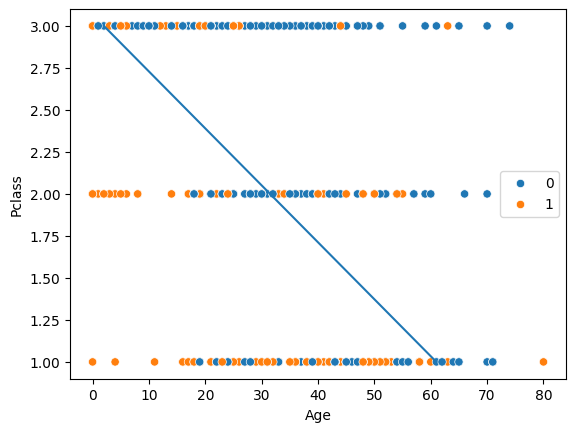

In [11]:
sns.scatterplot(x='Age', y='Pclass', hue="Survived", data=df_train[["Age", "Pclass", "Survived"]])
#sns.lineplot(x=np.array([2.0, 44.0]), y=np.array([3.0, 1.0]))
sns.lineplot(x=np.array([2.0, 61.0]), y=np.array([3.0, 1.0]))

In [12]:
# create features
X_train = df_train[["Age", "Pclass"]]
y_train = df_train["Survived"]
X_test  = df_test[["Age", "Pclass"]]
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((755, 2), (755,), (134, 2), (134,))

## Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train) * 100, 2)
acc_log
# score - відсоток правильних відповідей класифікатора

69.4

In [14]:
model.coef_, model.intercept_

(array([[-0.04640705, -1.19343273]]), array([3.60343122]))

In [ ]:
model.intercept_.item()

In [15]:
# f(x_1, x_2) = 0

# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] + model.intercept_.item() = 0
# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] = - model.intercept_.item()
#x_1*-0.04640705 = - (x_2*-1.19343273) - 3.60343122

# when x_1 = 0:
#x_2*1.19343273 - 3.60343122 = 0
#x_2*1.19343273 = 3.60343122
x_2_when_x_1_0 = 3.60343122/1.19343273
x_2_when_x_1_0

3.019383606145945

In [16]:
# when x_2 = 0:
#x_1*-0.04640705 = -3.60343122
x_1_when_x_2_0 = -3.60343122/-0.04640705
x_1_when_x_2_0

77.64835773874874

<Axes: xlabel='Age', ylabel='Pclass'>

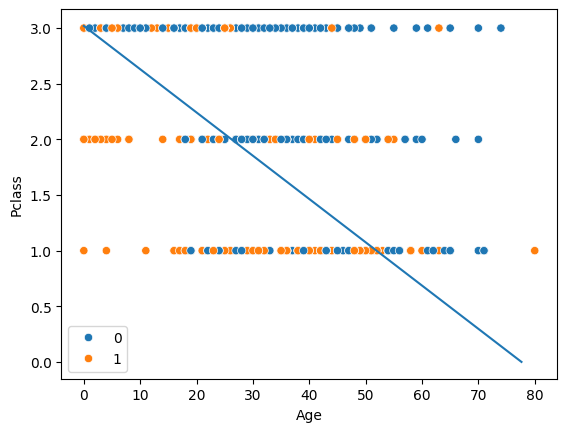

In [17]:
sns.scatterplot(x='Age', y='Pclass', hue="Survived", data=df_train[["Age", "Pclass", "Survived"]])
sns.lineplot(x=np.array([0.0, x_1_when_x_2_0]), y=np.array([x_2_when_x_1_0, 0.0]))
#sns.lineplot(x=np.array([2.0, 44.0]), y=np.array([3.0, 1.0]))
#sns.lineplot(x=np.array([2.0, 61.0]), y=np.array([3.0, 1.0]))

In [18]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
0,Age,-0.046407
1,Pclass,-1.193433


In [24]:
# add more features
X_train_df = df_train.drop("Survived", axis=1)
X_train = X_train_df.to_numpy()
y_train = df_train["Survived"]
X_test_df = df_test.drop("Survived", axis=1)
X_test  = df_test.drop("Survived", axis=1).to_numpy()
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((755, 7), (755,), (134, 7), (134,))

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train) * 100, 2)
acc_log
# score - відсоток правильних відповідей класифікатора

80.4

In [ ]:
# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] + x_3*model.coef_[0][2] + ... + model.intercept_.item() = 0

In [21]:
coeff_df = pd.DataFrame(X_train_df.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.540166
6,Embarked,0.196375
5,Fare,0.001283
4,Parch,-0.043302
2,Age,-0.047170
3,SibSp,-0.365331
0,Pclass,-1.247748


In [25]:
for feature_name, feature in zip(X_test_df.columns, X_test[0]):
    print(feature_name, feature)

Pclass 3.0
Sex 0.0
Age 28.0
SibSp 0.0
Parch 0.0
Fare 7.8542
Embarked 0.0


In [26]:
model.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0])

In [27]:
for feature_name, feature in zip(X_train_df.columns, X_test[1]):
    print(feature_name, feature)

Pclass 1.0
Sex 1.0
Age 14.0
SibSp 1.0
Parch 2.0
Fare 120.0
Embarked 0.0


In [28]:
# probabilities
model.predict_proba(X_test)

array([[0.89931387, 0.10068613],
       [0.03922801, 0.96077199],
       [0.3002072 , 0.6997928 ],
       [0.73684123, 0.26315877],
       [0.03478261, 0.96521739],
       [0.89506751, 0.10493249],
       [0.68863912, 0.31136088],
       [0.86510999, 0.13489001],
       [0.09560192, 0.90439808],
       [0.04417056, 0.95582944],
       [0.5872377 , 0.4127623 ],
       [0.4540927 , 0.5459073 ],
       [0.96358083, 0.03641917],
       [0.90514743, 0.09485257],
       [0.90332297, 0.09667703],
       [0.89759691, 0.10240309],
       [0.68446699, 0.31553301],
       [0.86985881, 0.13014119],
       [0.77872478, 0.22127522],
       [0.89043876, 0.10956124],
       [0.72042882, 0.27957118],
       [0.05902943, 0.94097057],
       [0.94747946, 0.05252054],
       [0.46247771, 0.53752229],
       [0.89041946, 0.10958054],
       [0.5095759 , 0.4904241 ],
       [0.75332419, 0.24667581],
       [0.0928075 , 0.9071925 ],
       [0.50679263, 0.49320737],
       [0.69933681, 0.30066319],
       [0.

In [29]:
# prob - see formula
# prob = 1 / (1 + math.e**-z)
import math

math.e

2.718281828459045

In [30]:
z = 1
1 / (1 + math.e**z)

0.2689414213699951

In [31]:
z = 2
1 / (1 + math.e**z)

0.11920292202211757

In [32]:
z = 3
1 / (1 + math.e**z)

0.04742587317756679

In [33]:
z = -1
1 / (1 + math.e**z)

0.7310585786300049

In [34]:
z = -2
1 / (1 + math.e**z)

0.8807970779778823

In [35]:
z = -3
1 / (1 + math.e**z)

0.9525741268224331

In [44]:
math.e**-1  # inverse
1 / math.e

0.36787944117144233

In [47]:
math.e**-2  # inverse
# 1 / math.e / math.e  
1 / (math.e * math.e)

0.1353352832366127

In [48]:
z = -10
math.e**-z

22026.465794806703

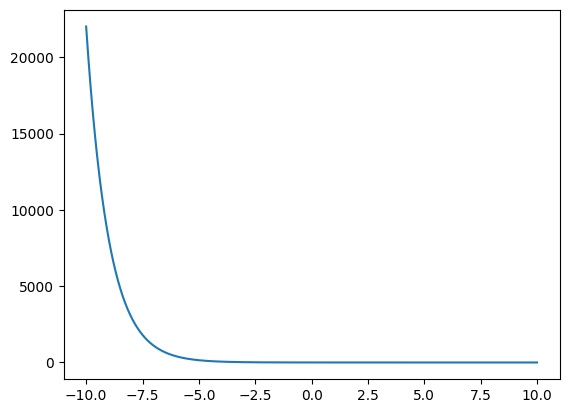

In [49]:
x = np.linspace(-10, 10, 100000)
y = math.e**-x
 
fig = plt.figure()
# Create the plot
plt.plot(x, y)

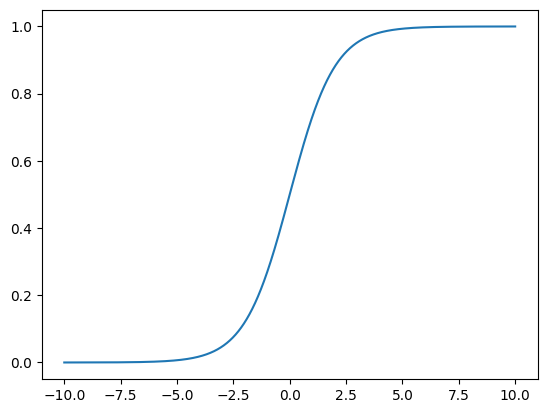

In [52]:
x = np.linspace(-10, 10, 100000)
y = 1 / (1 + math.e**-x)
 
fig = plt.figure()
# Create the plot
plt.plot(x, y)

In [56]:
#y = 1 / (math.e**-1 + 1)
y = 1 / (math.e**5.0 + 1)

y

0.006692850924284857

In [57]:
# Loss function

probs = model.predict_proba(X_test)
probs

array([[0.89931387, 0.10068613],
       [0.03922801, 0.96077199],
       [0.3002072 , 0.6997928 ],
       [0.73684123, 0.26315877],
       [0.03478261, 0.96521739],
       [0.89506751, 0.10493249],
       [0.68863912, 0.31136088],
       [0.86510999, 0.13489001],
       [0.09560192, 0.90439808],
       [0.04417056, 0.95582944],
       [0.5872377 , 0.4127623 ],
       [0.4540927 , 0.5459073 ],
       [0.96358083, 0.03641917],
       [0.90514743, 0.09485257],
       [0.90332297, 0.09667703],
       [0.89759691, 0.10240309],
       [0.68446699, 0.31553301],
       [0.86985881, 0.13014119],
       [0.77872478, 0.22127522],
       [0.89043876, 0.10956124],
       [0.72042882, 0.27957118],
       [0.05902943, 0.94097057],
       [0.94747946, 0.05252054],
       [0.46247771, 0.53752229],
       [0.89041946, 0.10958054],
       [0.5095759 , 0.4904241 ],
       [0.75332419, 0.24667581],
       [0.0928075 , 0.9071925 ],
       [0.50679263, 0.49320737],
       [0.69933681, 0.30066319],
       [0.

In [66]:
1 - 0.89931387

0.10068613000000004

In [58]:
probs_1 = probs[:, 1]
probs_1

array([0.10068613, 0.96077199, 0.6997928 , 0.26315877, 0.96521739,
       0.10493249, 0.31136088, 0.13489001, 0.90439808, 0.95582944,
       0.4127623 , 0.5459073 , 0.03641917, 0.09485257, 0.09667703,
       0.10240309, 0.31553301, 0.13014119, 0.22127522, 0.10956124,
       0.27957118, 0.94097057, 0.05252054, 0.53752229, 0.10958054,
       0.4904241 , 0.24667581, 0.9071925 , 0.49320737, 0.30066319,
       0.58451518, 0.74523311, 0.10958054, 0.54147552, 0.0366682 ,
       0.39509444, 0.70526404, 0.6940675 , 0.13035674, 0.10958054,
       0.14583371, 0.53166045, 0.3319398 , 0.10956124, 0.51170667,
       0.49147541, 0.78705676, 0.11899565, 0.22823663, 0.90626145,
       0.92593464, 0.76275688, 0.12935443, 0.11520425, 0.90699455,
       0.88555276, 0.4280506 , 0.06247929, 0.16495184, 0.26253738,
       0.33661269, 0.48757901, 0.77800823, 0.16500191, 0.83873614,
       0.38613821, 0.03815804, 0.10647863, 0.90127842, 0.96476745,
       0.29150109, 0.97822249, 0.68997137, 0.10513598, 0.40614

In [61]:
condition = probs_1 > 0.5
# probability of survival for surviving group
probs_1[condition]

array([0.96077199, 0.6997928 , 0.96521739, 0.90439808, 0.95582944,
       0.5459073 , 0.94097057, 0.53752229, 0.9071925 , 0.58451518,
       0.74523311, 0.54147552, 0.70526404, 0.6940675 , 0.53166045,
       0.51170667, 0.78705676, 0.90626145, 0.92593464, 0.76275688,
       0.90699455, 0.88555276, 0.77800823, 0.83873614, 0.90127842,
       0.96476745, 0.97822249, 0.68997137, 0.78329349, 0.82302922,
       0.57128875, 0.95155944, 0.87974187, 0.74523311, 0.65387277,
       0.70065785, 0.97532496, 0.52245736, 0.59815965, 0.9679922 ,
       0.6826543 , 0.90088953, 0.5651597 , 0.94591347, 0.9611482 ,
       0.9362534 , 0.53752229, 0.88323937, 0.74523311, 0.82556476])

In [62]:
# probability of survival for non-surviving group
probs_1[~condition]

array([0.10068613, 0.26315877, 0.10493249, 0.31136088, 0.13489001,
       0.4127623 , 0.03641917, 0.09485257, 0.09667703, 0.10240309,
       0.31553301, 0.13014119, 0.22127522, 0.10956124, 0.27957118,
       0.05252054, 0.10958054, 0.4904241 , 0.24667581, 0.49320737,
       0.30066319, 0.10958054, 0.0366682 , 0.39509444, 0.13035674,
       0.10958054, 0.14583371, 0.3319398 , 0.10956124, 0.49147541,
       0.11899565, 0.22823663, 0.12935443, 0.11520425, 0.4280506 ,
       0.06247929, 0.16495184, 0.26253738, 0.33661269, 0.48757901,
       0.16500191, 0.38613821, 0.03815804, 0.10647863, 0.29150109,
       0.10513598, 0.40614999, 0.14620222, 0.07441628, 0.38900838,
       0.17173736, 0.15411711, 0.05466091, 0.3319398 , 0.11416468,
       0.10958054, 0.08858439, 0.1292756 , 0.08124308, 0.11579312,
       0.10956124, 0.21948465, 0.18816621, 0.15411711, 0.11413874,
       0.08489278, 0.07294798, 0.05230586, 0.15302936, 0.1348557 ,
       0.14067331, 0.04363105, 0.11224622, 0.1065423 , 0.10336

In [63]:
# probability of non-survival for non-surviving group
1 - probs_1[~condition]

array([0.89931387, 0.73684123, 0.89506751, 0.68863912, 0.86510999,
       0.5872377 , 0.96358083, 0.90514743, 0.90332297, 0.89759691,
       0.68446699, 0.86985881, 0.77872478, 0.89043876, 0.72042882,
       0.94747946, 0.89041946, 0.5095759 , 0.75332419, 0.50679263,
       0.69933681, 0.89041946, 0.9633318 , 0.60490556, 0.86964326,
       0.89041946, 0.85416629, 0.6680602 , 0.89043876, 0.50852459,
       0.88100435, 0.77176337, 0.87064557, 0.88479575, 0.5719494 ,
       0.93752071, 0.83504816, 0.73746262, 0.66338731, 0.51242099,
       0.83499809, 0.61386179, 0.96184196, 0.89352137, 0.70849891,
       0.89486402, 0.59385001, 0.85379778, 0.92558372, 0.61099162,
       0.82826264, 0.84588289, 0.94533909, 0.6680602 , 0.88583532,
       0.89041946, 0.91141561, 0.8707244 , 0.91875692, 0.88420688,
       0.89043876, 0.78051535, 0.81183379, 0.84588289, 0.88586126,
       0.91510722, 0.92705202, 0.94769414, 0.84697064, 0.8651443 ,
       0.85932669, 0.95636895, 0.88775378, 0.8934577 , 0.89663

In [67]:
# probability of survival for surviving group * probability of non-survival for non-surviving group
(np.prod(probs_1[condition]))*(np.prod(1 - probs_1[~condition]))

1.5328626903946836e-14

In [72]:
-(np.sum(np.log(probs_1[condition])))+(np.sum(np.log(1 - probs_1[~condition])))

-5.392833830116741

In [73]:
y_test_array = y_test.to_numpy()
y_test_array

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0])

In [79]:
probs[1][1]*1

0.9607719908649808

In [80]:
condition[1]

True

In [82]:
(1-0)*probs[0][1]

0.10068612530347204

In [83]:
# rewrite the formula
-np.sum(y_test_array*np.log(probs)[:, 1] + (1 - y_test_array)*(np.log(1 - (probs)[:, 1])))

56.360632491976396

In [95]:
# probability of survival for surviving group + probability of non-survival for non-surviving group
-np.sum(y_test_array*np.log(probs)[:, 1] + (1 - y_test_array)*np.log(probs)[:, 0]) / len(probs)

0.42060173501474923

In [88]:
from sklearn.metrics import log_loss
log_loss(y_test, probs)#, normalize=False)

0.42060173501474923

In [90]:
# probability of non-survival for non-surviving group
y_test_array*np.log(probs)[:, 1]

array([-0.        , -0.04001816, -0.35697099, -0.        , -0.03540193,
       -2.25443805, -0.        , -0.        , -0.10048566, -0.04517579,
       -0.        , -0.60530609, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.06084341, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.09740062, -0.        , -0.        ,
       -0.53697253, -0.29405821, -0.        , -0.        , -0.        ,
       -0.        , -0.34918303, -0.36518607, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.67000372,
       -0.71034337, -0.        , -0.        , -0.        , -0.09842744,
       -0.07695163, -0.27081593, -0.        , -0.        , -0.09761884,
       -0.12154324, -0.        , -0.        , -0.        , -0.        ,
       -1.08882229, -0.        , -0.25101818, -0.        , -0.17585912,
       -0.        , -0.        , -0.        , -0.10394106, -0.03

In [89]:
# probability of non-survival for non-surviving group
(1-y_test.to_numpy())*(1-np.log(probs)[:, 1])

array([3.29574727, 0.        , 0.        , 2.33499774, 0.        ,
       0.        , 2.16680264, 3.00329557, 0.        , 0.        ,
       1.88488339, 0.        , 4.31266011, 3.35543152, 3.33637943,
       3.27883837, 2.15349199, 3.03913537, 2.50834801, 3.21127161,
       2.27449833, 0.        , 3.94655089, 1.62078504, 3.21109548,
       1.71248474, 2.39968031, 0.        , 1.70682557, 2.2017646 ,
       0.        , 0.        , 3.21109548, 1.61345742, 4.30584545,
       1.92863046, 0.        , 0.        , 3.03748041, 3.21109548,
       2.92528829, 1.63175024, 2.10280164, 3.21127161, 0.        ,
       0.        , 1.23945491, 3.12866831, 2.47737234, 0.        ,
       0.        , 0.        , 3.04519911, 3.16104868, 0.        ,
       0.        , 1.84851387, 3.77292012, 2.8021017 , 2.33736181,
       0.        , 1.71830293, 0.        , 2.80179824, 0.        ,
       1.95155992, 4.26601887, 3.23981097, 0.        , 0.        ,
       2.23271154, 1.02201814, 1.37110517, 0.        , 0.     

In [91]:
# Logarithms: https://www.mathsisfun.com/algebra/logarithms.html
math.log(8, 2)

3.0

In [92]:
math.e ** 2.0794

7.999667673464062

In [94]:
math.log(8, math.e) == math.log(8)

True

## Other classification models

In [102]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss="log_loss")  # logistic regression
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd
# score - відсоток правильних відповідей класифікатора

68.08

Gradient Descent
![gradient_descent](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*N5WjbzwsCFse-KPjBWZZ6g.jpeg)
![gradient_descent_complex](https://miro.medium.com/v2/resize:fit:900/format:webp/1*jeMxJLZz-o5xniDMKqcTAg.jpeg)

In [103]:
probs_sgd = sgd.predict_proba(X_test)
log_loss(y_test, probs_sgd)

9.719355696627373

In [117]:
# Gradient Descent calculation example
x = np.linspace(0,10,1000)
dx = x[1]-x[0]
y = x**2 + 1
dydx = np.gradient(y, dx)
dydx[:20]

array([0.01001001, 0.02002002, 0.04004004, 0.06006006, 0.08008008,
       0.1001001 , 0.12012012, 0.14014014, 0.16016016, 0.18018018,
       0.2002002 , 0.22022022, 0.24024024, 0.26026026, 0.28028028,
       0.3003003 , 0.32032032, 0.34034034, 0.36036036, 0.38038038])

In [109]:
(0.0003/len(dydx))*np.sum(dydx)

0.003

In [111]:
# RidgeClassifier
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
Y_pred = ridge.predict(X_test)
acc_ridge = round(ridge.score(X_train, y_train) * 100, 2)
acc_ridge

79.87

## Multi-class classification

In [112]:
# Стратегія "один проти всіх"
from sklearn.multiclass import OneVsRestClassifier
# create features
X_train = df_train[["Age", "Survived"]]
y_train = df_train["Pclass"]
X_test  = df_test[["Age", "Survived"]]
y_test = df_test["Pclass"]

clf = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)
preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [113]:
y_test.to_numpy()

array([3, 1, 3, 2, 1, 3, 2, 3, 1, 1, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1,
       3, 1, 3, 1, 2, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 2, 3, 2, 3,
       1, 1, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 1, 3, 2, 2,
       3, 3, 1, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 2, 2,
       2, 3])

In [114]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6556291390728477, 'Test', 0.6119402985074627)

In [115]:
# Стратегія "один проти одного"

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

clf = OneVsOneClassifier(
    LogisticRegression(random_state=0)).fit(X_train, y_train)

preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [116]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6569536423841059, 'Test', 0.6119402985074627)